In [2]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from kmeans import Kmeans

from pca import PCAPlotting

1. import merged data
2. remove regions that contain >= 85% of data being NaN
3. fill all NaNs with 0s

In [21]:
from data import Data
data = Data()
data.filter_low_data_regions(threshold=0.15)
data.fill_na(0)
data.normalize_regions()
dat = data.d

c:\users\julian\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3417: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


`region_validation_splits` generates test splits grouped by regions

In [6]:
def region_validation_splits(d, n_splits=5):
    regions = d["open_covid_region_code"].unique()
    kf = KFold(n_splits=n_splits)
    for train_i, val_i in kf.split(regions):
        train = regions[train_i]
        val = regions[val_i]
        dat_train = d[d["open_covid_region_code"].isin(train)]
        dat_val = d[d["open_covid_region_code"].isin(val)]
        x_train = dat_train.iloc[:, 6:-1]
        y_train = dat_train.iloc[:, -1]
        x_val = dat_val.iloc[:, 6:-1]
        y_val = dat_val.iloc[:, -1]
        yield x_train, y_train, x_val, y_val

`time_validation_split` splits the data into two sets: before and after a given time.

In [7]:
def time_validation_split(d, split_date):
    dat_train = d[d["date"] <= split_date]
    dat_val = d[d["date"] > split_date]
    x_train = dat_train.iloc[:, 6:-1]
    y_train = dat_train.iloc[:, -1]
    x_val = dat_val.iloc[:, 6:-1]
    y_val = dat_val.iloc[:, -1]
    yield x_train, y_train, x_val, y_val

Mean Squared Error

In [8]:
def calc_MSE(model, validation_sets):
    squared_error = 0
    n_validations = 0
    for x_train, y_train, x_val, y_val in validation_sets:
        model.fit(x_train, y_train)
        pred = model.predict(x_val)
        squared_error += sum((pred - y_val) ** 2)
        n_validations += x_val.shape[0]
    return squared_error / n_validations

KNN performance on region cross validation. This outputs the best K and it's corresponding
mean squared error.

In [22]:
n_neighbors = np.zeros(100)
for i in range(n_neighbors.shape[0]):
    neigh = KNeighborsRegressor(n_neighbors=i+1)
    n_neighbors[i] = calc_MSE(neigh, region_validation_splits(dat, n_splits=5))
best = np.argmin(n_neighbors) + 1
print(f"best K = {best}, MSE = {n_neighbors[best - 1]}")

best K = 100, MSE = 2306.6143465789473


Regression Tree performance on region cross validation. It uses minimum samples per leaf
as a hyperparameter. This outputs the best min_sample_leaf and it's corresponding
mean squared error.

In [19]:
leaf_samples = np.zeros(100)
for i in range(leaf_samples.shape[0]):
    tree = DecisionTreeRegressor(min_samples_leaf=i+1)
    leaf_samples[i] = calc_MSE(tree, region_validation_splits(dat, n_splits=5))
best = np.argmin(leaf_samples) + 1
print(f"best min_samples_leaf = {best}, MSE = {leaf_samples[best - 1]}")

best min_samples_leaf = 28, MSE = 2258.1146108941984


KNN performance on time split validation. This outputs the best K and it's corresponding
mean squared error.

In [18]:
n_neighbors = np.zeros(200)
for i in range(n_neighbors.shape[0]):
    neigh = KNeighborsRegressor(n_neighbors=i+1)
    n_neighbors[i] = calc_MSE(neigh, time_validation_split(dat, "2020-08-10"))
best = np.argmin(n_neighbors) + 1
print(f"best K = {best}, MSE = {n_neighbors[best - 1]}")

best K = 1, MSE = 972.1166666666667


Regression Tree performance on time split validation. It uses minimum samples per leaf
as a hyper-parameter. This outputs the best min_sample_leaf and it's corresponding
mean squared error.

In [17]:
leaf_samples = np.zeros(200)
for i in range(leaf_samples.shape[0]):
    tree = DecisionTreeRegressor(min_samples_leaf=i+1)
    leaf_samples[i] = calc_MSE(tree, time_validation_split(dat, "2020-08-10"))
best = np.argmin(leaf_samples) + 1
print(f"best min_samples_leaf = {best}, MSE = {leaf_samples[best - 1]}")

best min_samples_leaf = 1, MSE = 1155.3


This is an attempt at using a model on the PCA-reduced dataset and ordinary 5-fold
cross validation is used.

In [13]:
pca = PCAPlotting(dat)
pca.reduce_dimensionality(new_dimension=2)
pca.add_hospitalized_new()
X = pca.reduced_data[:,:-1]
y = pca.reduced_data[:,-1]
kf = KFold(n_splits=5)

mse = np.zeros(200)
for i in range(mse.shape[0]):
    sqr_err = 0
    n_test = 0
    for train_i, test_i in kf.split(X):
        model = KNeighborsRegressor(n_neighbors=i+1)
        # model = DecisionTreeRegressor(min_samples_leaf=i+1)
        model.fit(X[train_i], y[train_i])
        pred = model.predict(X[test_i])
        sqr_err += np.sum((pred - y[test_i]) ** 2)
        n_test += test_i.shape[0]
    mse[i] = sqr_err / n_test
best = np.argmin(mse) + 1
print(f"best = {best}, MSE = {mse[best - 1]}")

best = 193, MSE = 2230.5781958116854


The following charts show why the MSE is so high. similar features cluster together but
their corresponding labels (z-axis) have high variance.

c:\users\julian\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3417: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


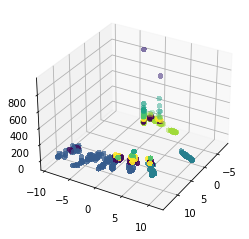

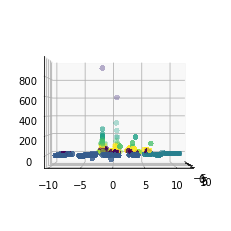

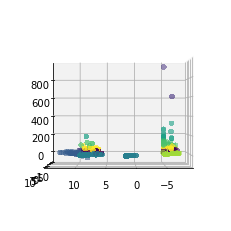

In [23]:
dataset = Data()
dataset.fill_na(0)
dataset.filter_out_zeros()
dataset.normalize_regions()
pca_data = PCAPlotting(dataset.d)
pca_data.reduce_dimensionality(2)
pca_data.add_hospitalized_new()
kmeans = Kmeans(pca_data.reduced_data)
kmeans.find_clusters(8)
kmeans.plot_3d_kmeans(view_init=(30, 30))
kmeans.plot_3d_kmeans(view_init=(0, 0))
kmeans.plot_3d_kmeans(view_init=(0, 90))